# Chapter 26: Advanced pandas Techniques

MultiIndex, method chaining, performance optimization, and real-world patterns



### MultiIndex (Hierarchical Indexing) (Slide 121)


In [1]:
# pd.MultiIndex.from_tuples(list)  — create from tuples
# pd.MultiIndex.from_arrays(lists) — create from arrays
# pd.MultiIndex.from_product(lists) — create from cross product
# .loc[(level1, level2)]           — select by multiple levels
# .xs(key, level=N)               — cross-section select

import pandas as pd
import numpy as np

# Create MultiIndex from tuples
index = pd.MultiIndex.from_tuples(
    [('CA', 2023), ('CA', 2024), ('NY', 2023), ('NY', 2024)],
    names=['state', 'year'])
df = pd.DataFrame({'pop': [39, 39.5, 20, 20.2],
                   'gdp': [3.5, 3.7, 1.8, 1.9]}, index=index)
print(df)

# Select by outer level
print(df.loc['CA'])

# Select by both levels
print(df.loc[('CA', 2024)])

# Cross-section: all states for 2024
print(df.xs(2024, level='year'))

# Swap and sort levels
print(df.swaplevel().sort_index())


             pop  gdp
state year           
CA    2023  39.0  3.5
      2024  39.5  3.7
NY    2023  20.0  1.8
      2024  20.2  1.9
       pop  gdp
year           
2023  39.0  3.5
2024  39.5  3.7
pop    39.5
gdp     3.7
Name: (CA, 2024), dtype: float64
        pop  gdp
state           
CA     39.5  3.7
NY     20.2  1.9
             pop  gdp
year state           
2023 CA     39.0  3.5
     NY     20.0  1.8
2024 CA     39.5  3.7
     NY     20.2  1.9


> **Note:** MultiIndex enables efficient storage and selection of grouped data


### Method Chaining (Slide 122)


In [2]:
# Method chaining = calling multiple methods in sequence
# Makes code readable like a pipeline
# .pipe(func)  — apply any function in a chain
# .assign(col=expr) — add computed column in a chain
# .query('expr')    — filter rows with string expression

import pandas as pd
import numpy as np

df = pd.DataFrame({'name': ['Alice', 'Bob', 'Charlie', 'Diana'],
                   'score': [85, 92, 78, 95],
                   'dept': ['Sales', 'Engineering', 'Sales', 'Engineering']})

# Unchained (hard to read)
df2 = df[df['score'] > 80]
df2 = df2.sort_values('score', ascending=False)
df2 = df2.reset_index(drop=True)

# Chained (cleaner!)
result = (df
  .query('score > 80')
  .sort_values('score', ascending=False)
  .reset_index(drop=True)
  .assign(grade=lambda x: np.where(x['score'] >= 90, 'A', 'B'))
)
print(result)

# Using pipe for custom functions
def add_rank(df, col):
    return df.assign(rank=df[col].rank(ascending=False))

result = df.pipe(add_rank, 'score')
print(result)


    name  score         dept grade
0  Diana     95  Engineering     A
1    Bob     92  Engineering     A
2  Alice     85        Sales     B
      name  score         dept  rank
0    Alice     85        Sales   3.0
1      Bob     92  Engineering   2.0
2  Charlie     78        Sales   4.0
3    Diana     95  Engineering   1.0


> **Note:** Chain methods for readable, pipeline-style data transformations


### eval() & query(): Fast Expressions (Slide 123)


In [3]:
# df.eval('expr')   — compute expression using column names
# df.query('expr')  — filter rows using string expression
# Faster than regular Python for large DataFrames
# Can reference local variables with @

import pandas as pd
import numpy as np

np.random.seed(42)
df = pd.DataFrame({'A': np.random.randn(10000),
                   'B': np.random.randn(10000),
                   'C': np.random.randn(10000)})

# eval: compute new columns efficiently
df.eval('D = A + B * C', inplace=True)
df.eval('E = (A > 0) & (B > 0)', inplace=True)

# query: filter rows with string expressions
result = df.query('A > 0 and B > 0')
print(result.shape)  # Only rows where both A and B positive

# query with 'or', 'not'
result = df.query('A > 1 or B < -1')
result = df.query('not (A > 0)')

# Reference local variables with @
threshold = 1.5
result = df.query('A > @threshold')
print(result.shape)

# query with column names containing spaces
# df.query('`Column Name` > 0')


(2510, 5)
(676, 5)


> **Note:** query/eval use string expressions — faster for large DataFrames


### Window Functions (Slide 124)


In [4]:
# .rolling(N)     — sliding window of N rows
# .expanding()    — cumulative from start to current row
# .ewm(span=N)   — exponentially weighted (recent = more weight)
# Works with groupby: df.groupby('key')['val'].rolling(N)

import pandas as pd
import numpy as np

np.random.seed(42)
df = pd.DataFrame({'date': pd.date_range('2024', periods=100),
                   'group': ['A', 'B'] * 50,
                   'value': np.random.randn(100).cumsum()})

# Rolling mean per group
df['rolling_mean'] = (df.groupby('group')['value']
                       .transform(lambda x: x.rolling(7).mean()))

# Cumulative sum per group
df['cum_sum'] = df.groupby('group')['value'].cumsum()

# Rank within group
df['rank'] = df.groupby('group')['value'].rank(ascending=False)

# Rolling correlation between two columns
df['A_val'] = np.random.randn(100)
df['B_val'] = np.random.randn(100)
roll_corr = df['A_val'].rolling(20).corr(df['B_val'])
print(roll_corr.tail())


95   -0.446089
96   -0.471601
97   -0.446362
98   -0.437174
99   -0.493130
dtype: float64


> **Note:** Combine groupby + rolling for per-group moving calculations


### Memory Optimization (Slide 125)


In [5]:
# .memory_usage(deep=True)  — actual memory per column
# .astype('category')       — ~90% savings on repeated strings
# .astype('int32')          — downcast numeric types
# pd.to_numeric(downcast='integer') — auto-downcast
# Sparse dtypes for mostly-NaN data

import pandas as pd
import numpy as np

# Create a large DataFrame
N = 1_000_000
df = pd.DataFrame({
    'id': range(N),
    'category': np.random.choice(['A', 'B', 'C', 'D'], N),
    'value': np.random.randn(N),
    'flag': np.random.choice([True, False], N)
})

# Check memory usage
print(df.memory_usage(deep=True) / 1e6)  # MB per column

# Optimize category column (string → category)
df['category'] = df['category'].astype('category')

# Downcast numerics
df['value'] = df['value'].astype('float32')  # 64→32 bit
df['id'] = pd.to_numeric(df['id'], downcast='integer')

print(df.memory_usage(deep=True) / 1e6)  # Much smaller!

# Read CSV with optimized types from the start
# df = pd.read_csv('data.csv', dtype={'cat_col': 'category'})


Index        0.000132
id           8.000000
category    50.000000
value        8.000000
flag         1.000000
dtype: float64


Index       0.000132
id          4.000000
category    1.000200
value       4.000000
flag        1.000000
dtype: float64


> **Note:** category + float32 can reduce memory by 70%+ on large datasets


### Practical: Full Analysis Pipeline (Slide 126)


product       Doohickey       Gadget       Widget
date                                             
2024-08-31  1419.373710   329.922222  1942.812107
2024-09-30  1128.024357   986.360215   757.681644
2024-10-31  1389.775235  1290.209582   978.149569
2024-11-30   882.285673   925.254914  1533.024152
2024-12-31   895.860304  1191.978014  1332.444498


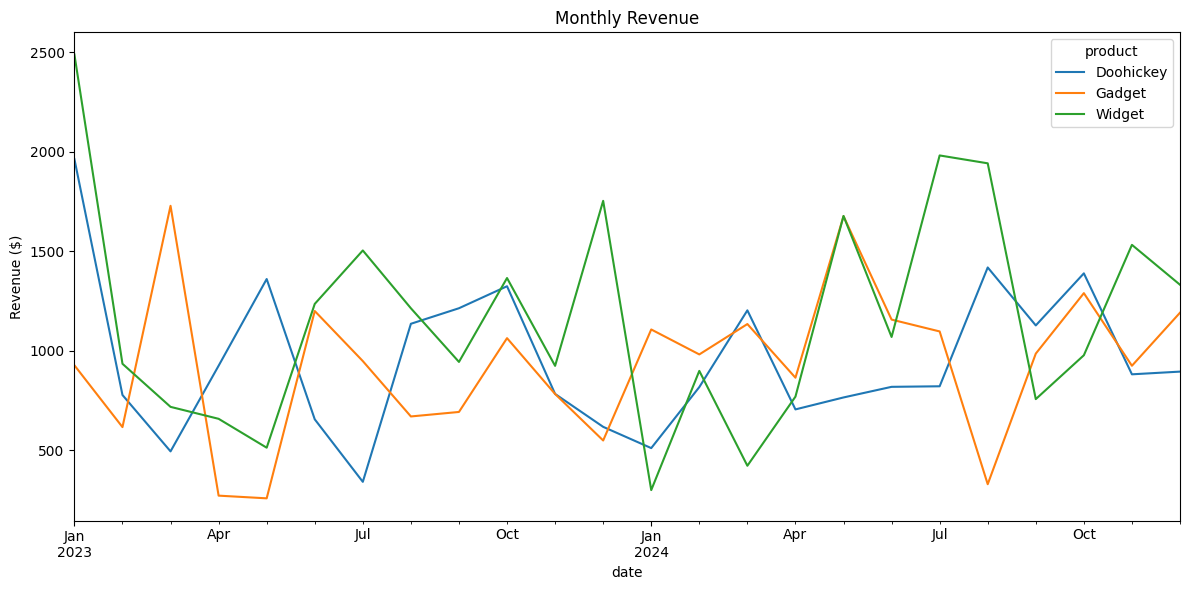

In [6]:
# Putting it all together: load → clean → transform → analyze → visualize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Create sample sales data
np.random.seed(42)
dates = pd.date_range('2023-01-01', '2024-12-31', freq='D')
df = pd.DataFrame({
    'date': dates,
    'product': np.random.choice(['Widget', 'Gadget', 'Doohickey'], len(dates)),
    'revenue': np.random.exponential(100, len(dates)),
    'units': np.random.randint(1, 50, len(dates))
})

# Step 2: Clean & Transform (chained)
result = (df
  .assign(date=lambda x: pd.to_datetime(x['date']))
  .set_index('date')
  .assign(avg_price=lambda x: x['revenue'] / x['units'])
  .query('revenue > 10')
)

# Step 3: Analyze (resample + groupby)
monthly = result.groupby('product').resample('ME')['revenue'].sum()
print(monthly.unstack(level=0).tail())

# Step 4: Visualize
monthly.unstack(level=0).plot(figsize=(12, 6), title='Monthly Revenue')
plt.ylabel('Revenue ($)')
plt.tight_layout()
plt.show()


> **Note:** load → clean → transform → analyze → visualize = the full pipeline


### Data Analysis Course Summary (Slide 127)


<p><strong>🎉 Congratulations!</strong> You've completed the Data Analysis with Python module!</p>
<p><strong>What You've Learned:</strong></p>
<table>
<tr><th>Chapter</th><th>Topic</th><th>Key Skills</th></tr>
<tr><td>19</td><td>NumPy</td><td>Arrays, vectorized ops, broadcasting</td></tr>
<tr><td>20</td><td>pandas Basics</td><td>Series, DataFrame, indexing, selection</td></tr>
<tr><td>21</td><td>Data Loading</td><td>CSV, JSON, Excel, SQL, web APIs</td></tr>
<tr><td>22</td><td>Data Cleaning</td><td>Missing data, strings, duplicates, types</td></tr>
<tr><td>23</td><td>Data Wrangling</td><td>Merge, concat, reshape, groupby</td></tr>
<tr><td>24</td><td>Visualization</td><td>matplotlib, pandas plot, seaborn</td></tr>
<tr><td>25</td><td>Time Series</td><td>Dates, resampling, rolling, time zones</td></tr>
<tr><td>26</td><td>Advanced pandas</td><td>MultiIndex, chaining, optimization</td></tr>
</table>
<p><strong>Next Steps:</strong></p>
<ul>
<li>Practice with real datasets (Kaggle, government data portals)</li>
<li>Build end-to-end projects: load → clean → analyze → visualize</li>
<li>Explore: scikit-learn (ML), statsmodels (statistics), plotly (interactive viz)</li>
</ul>


> **Note:** The best way to learn is by doing — find a dataset that interests you!
